# Part 1 - EDA & Single Video Analysis

## Table of Contents
1. [Understanding the data](#section1)
2. [Determine all detected objects](#section2)
3. [Determine all detected emotions](#section3)
4. [Determine the detected object with greatest probability score](#section4) 
5. [Person analysis](#section5)
6. [Face analysis](#section6)
7. [Pose analysis](#section7)
8. [Determine who is the most visible person in the whole debate](#section8)  
    &nbsp;&nbsp;&nbsp;&nbsp;8.1 [Classification with face embeddings](#section8.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.1.1 [Using the whole dataset](#section8.1.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.1.2 [Using only single person scenes](#section8.1.2)  
    &nbsp;&nbsp;&nbsp;&nbsp;8.2 [Person classification with positional embeddings](#section8.2)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.2.1 [Using only single person scenes](#section8.2.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.2.1 [Using only two person scenes](#section8.2.2)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.2.1 [Using only panorama scenes](#section8.2.3)  
    &nbsp;&nbsp;&nbsp;&nbsp;8.3 [Comparison between face and positional classifications](#section8.3)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.3.1 [For both genders](#section8.3.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.3.2 [For only females](#section8.3.2)   
    &nbsp;&nbsp;&nbsp;&nbsp;8.4 [Image embeddings classification](#section8.4) 
9. [Scene dynamics over time](#section9)   
10. [Emotions in 1v1 frames](#section10) 



### Import libraries

In [108]:
import numpy as np
import pandas as pd
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from collections import defaultdict
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from collections import Counter

## List of available electoral debates

In [2]:
videos = [f for f in os.listdir('videos')]
print(videos)

['ad-be', 'ad-cdu', 'ad-chega', 'ad-il', 'ad-livre', 'ad-pan', 'ad-ps', 'be-ps', 'cdu-be', 'cdu-ps', 'chega-be', 'chega-cdu', 'chega-il', 'chega-ps', 'il-be', 'il-cdu', 'il-ps', 'livre-be', 'livre-cdu', 'livre-chega', 'livre-il', 'livre-ps', 'pan-be', 'pan-cdu', 'pan-chega', 'pan-il', 'pan-livre', 'pan-ps']


### Select electrocal debate for analysis:

In [3]:
video = 'ad-be'

In [4]:
df = pd.read_pickle(os.path.join('pickles', video + '.pkl'))
df.head()

filename                                         detections  \
0  img00116.jpeg          [[166, 59, 671, 660, person, 0.83203125]]   
1  img01657.jpeg  [[618, 31, 633, 686, person, 0.94140625], [26,...   
2  img00589.jpeg  [[619, 52, 658, 673, person, 0.9375], [0, 38, ...   
3  img00264.jpeg  [[549, 187, 133, 158, person, 0.69921875], [81...   
4  img00070.jpeg          [[202, 65, 598, 648, person, 0.87890625]]   

                                               poses  \
0  [[[0.5391421914100647, 0.36607205867767334, -0...   
1  [[[0.27856743335723877, 0.3202641010284424, -0...   
2  [[[0.25045064091682434, 0.37025511264801025, -...   
3  [[[0.7415872812271118, 0.28317856788635254, -0...   
4  [[[0.47433674335479736, 0.3892367482185364, -0...   

                                               faces text  \
0  [[[0.5395416617393494, 0.41458719968795776, -0...   []   
1  [[[0.27625948190689087, 0.364106148481369, -0....   []   
2  [[[0.736098051071167, 0.41370394825935364, -0....   []   
3                                                 []   []   
4  [[[0.4738401770591736, 0.43417638540267944, -0...   []   

                                           embedding  \
0  [253, 6, 253, 254, 2, 0, 8, 255, 1, 254, 253, ...   
1  [255, 4, 1, 255, 0, 253, 254, 253, 4, 0, 0, 3,...   
2  [253, 5, 2, 1, 254, 253, 255, 254, 11, 3, 0, 3...   
3  [254, 253, 2, 3, 254, 253, 254, 0, 254, 253, 0...   
4  [253, 3, 253, 253, 4, 1, 12, 254, 3, 255, 253,...   

                                                 fer  
0  [{'location': [499, 757, 117, 376], 'embedding...  
1  [{'location': [778, 1016, 62, 300], 'embedding...  
2  [{'location': [188, 453, 116, 381], 'embedding...  
3  [{'location': [929, 994, 163, 229], 'embedding...  
4  [{'location': [423, 676, 132, 386], 'embedding...

<a id="section1"></a>

# 1. Understanding the data

## Run descriptive statistics

In [5]:
df.dtypes

filename      object
detections    object
poses         object
faces         object
text          object
embedding     object
fer           object
dtype: object

In [6]:
df.describe(include='all')

filename                                 detections  \
count            2060                                       2060   
unique           2060                                       1980   
top     img00116.jpeg  [[362, 65, 738, 648, person, 0.93359375]]   
freq                1                                          4   

                                                    poses faces  text  \
count                                                2060  2060  2060   
unique                                               2060  1905     7   
top     [[[0.5391421914100647, 0.36607205867767334, -0...    []    []   
freq                                                    1   156  2054   

                                                embedding  \
count                                                2060   
unique                                               2060   
top     [253, 6, 253, 254, 2, 0, 8, 255, 1, 254, 253, ...   
freq                                                    1   

                                                      fer  
count                                                2060  
unique                                               2060  
top     [{'location': [499, 757, 117, 376], 'embedding...  
freq                                                    1

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    2060 non-null   object
 1   detections  2060 non-null   object
 2   poses       2060 non-null   object
 3   faces       2060 non-null   object
 4   text        2060 non-null   object
 5   embedding   2060 non-null   object
 6   fer         2060 non-null   object
dtypes: object(7)
memory usage: 112.8+ KB


## Look at an observation

In [8]:
# Select index
i=0

In [9]:
df.iloc[i]['detections']

[[166, 59, 671, 660, 'person', 0.83203125]]

In [10]:
df['poses'][i]

[[[0.5391421914100647,
   0.36607205867767334,
   -0.4430074095726013,
   0.9988310933113098,
   0.9973727464675903],
  [0.52968430519104,
   0.31001710891723633,
   -0.4112609922885895,
   0.9975869655609131,
   0.9977019429206848],
  [0.5295490026473999,
   0.3050955533981323,
   -0.4118358790874481,
   0.9979731440544128,
   0.998320996761322],
  [0.5293174386024475,
   0.2996549606323242,
   -0.41191330552101135,
   0.9984593391418457,
   0.9982373714447021],
  [0.5161058902740479,
   0.31159067153930664,
   -0.47958269715309143,
   0.9987070560455322,
   0.9970940351486206],
  [0.5075369477272034,
   0.31024789810180664,
   -0.4802638590335846,
   0.9991208910942078,
   0.9980098605155945],
  [0.4979414939880371,
   0.30871033668518066,
   -0.48059672117233276,
   0.9992885589599609,
   0.99802565574646],
  [0.47541582584381104,
   0.32254648208618164,
   -0.21589212119579315,
   0.9994385838508606,
   0.999249279499054],
  [0.4437870383262634,
   0.3190845251083374,
   -0.5214800

In [11]:
df.iloc[i]['faces']

[[[0.5395416617393494, 0.41458719968795776, -0.013746370561420918, 0.0, 0.0],
  [0.5472124814987183, 0.37194913625717163, -0.01886342652142048, 0.0, 0.0],
  [0.5339860320091248, 0.38654637336730957, -0.01212855614721775, 0.0, 0.0],
  [0.5345162749290466, 0.3349182903766632, -0.016541333869099617, 0.0, 0.0],
  [0.5480954051017761, 0.3593595325946808, -0.01975381188094616, 0.0, 0.0],
  [0.54388028383255, 0.34540289640426636, -0.01753339171409607, 0.0, 0.0],
  [0.528046190738678, 0.3114280700683594, -0.0044209910556674, 0.0, 0.0],
  [0.4902205467224121, 0.2984778583049774, -0.02527972124516964, 0.0, 0.0],
  [0.5233330726623535, 0.28576797246932983, 0.0006437430856749415, 0.0, 0.0],
  [0.5243407487869263, 0.271575927734375, 0.0013548299903050065, 0.0, 0.0],
  [0.5205212235450745, 0.2147635519504547, 0.010138304904103279, 0.0, 0.0],
  [0.5390348434448242, 0.4216904938220978, -0.013571267016232014, 0.0, 0.0],
  [0.5373204946517944, 0.4279917776584625, -0.012603280134499073, 0.0, 0.0],
  [0.5

In [12]:
print(df.iloc[i]['embedding'])
embedding = np.array(df['embedding'][0])

[253   6 253 ...   1   1   6]


In [13]:
print(df.iloc[i]['fer'])

[{'location': [499, 757, 117, 376], 'embedding': [-0.016630223020911217, -0.012691124342381954, 0.061645444482564926, 0.07406854629516602, 0.01282584946602583, 0.08636020869016647, 0.1149119958281517, -0.041829559952020645, 0.036307159811258316, 0.0831577256321907, -0.014483298175036907, 0.0829959437251091, -0.03635471686720848, 0.0980047658085823, -0.042078617960214615, -0.10987995564937592, 0.1098342016339302, -0.022085677832365036, 0.010466662235558033, 0.03912307322025299, 0.16859495639801025, 0.02917638048529625, -0.03404663875699043, -0.10409899801015854, 0.009123400785028934, -0.0469338558614254, -0.011399075388908386, 0.1975606083869934, 0.12084954231977463, 0.027586348354816437, -0.04441011697053909, -0.0014740211190655828, -0.17182590067386627, -0.03426498547196388, 0.16394111514091492, 0.09482107311487198, -0.15831565856933594, -0.14478887617588043, 0.001731710508465767, -0.12793369591236115, 0.03075922653079033, 0.046695735305547714, 0.17775672674179077, -0.0767433270812034

In [14]:
np.shape(df.iloc[i]['detections'])

(1, 6)

In [15]:
np.shape(df.iloc[i]['poses'])

(1, 33, 5)

In [16]:
np.shape(df.iloc[i]['faces'])

(1, 478, 5)

In [17]:
np.shape(df.iloc[i]['embedding'])

(1024,)

In [18]:
np.shape(df.iloc[i]['fer'])

(1,)

## Quickly verify that all objects are in the expected shape

In [19]:
# Expected data format for each type of object
detection_len = 6
pose_shape = (33, 5)
embedding_len = 1024
fer_location_len = 4
fer_embedding_len = 128

In [20]:
df['detections'] = df['detections'].apply(
    lambda x: [] if len(x)==0 or (np.shape(x)[1] != detection_len) else x)

df['poses'] = df['poses'].apply(
    lambda x: [] if len(x)==0 or (np.shape(x)[-2:] != pose_shape) else x)

df['embedding'] = df['embedding'].apply(lambda x: {} if len(x)==0 or (len(x) != embedding_len) else x)

### Comparing the results to the previous description table, we conclude that all objects are in the correct format.

In [21]:
df.describe()

filename                                 detections  \
count            2060                                       2060   
unique           2060                                       1980   
top     img00116.jpeg  [[362, 65, 738, 648, person, 0.93359375]]   
freq                1                                          4   

                                                    poses faces  text  \
count                                                2060  2060  2060   
unique                                               2060  1905     7   
top     [[[0.5391421914100647, 0.36607205867767334, -0...    []    []   
freq                                                    1   156  2054   

                                                embedding  \
count                                                2060   
unique                                               2060   
top     [253, 6, 253, 254, 2, 0, 8, 255, 1, 254, 253, ...   
freq                                                    1   

                                                      fer  
count                                                2060  
unique                                               2060  
top     [{'location': [499, 757, 117, 376], 'embedding...  
freq                                                    1

## Order the dataframe by image frame

In [22]:
df = df.sort_values(by='filename').reset_index(drop=True)
df

filename                                  detections  \
0     img00001.jpeg   [[265, 52, 828, 673, person, 0.94140625]]   
1     img00002.jpeg   [[278, 38, 828, 673, person, 0.94140625]]   
2     img00003.jpeg   [[248, 59, 860, 660, person, 0.92578125]]   
3     img00004.jpeg       [[265, 59, 828, 660, person, 0.9375]]   
4     img00005.jpeg   [[248, 65, 860, 648, person, 0.93359375]]   
...             ...                                         ...   
2055  img02056.jpeg   [[293, 86, 797, 635, person, 0.95703125]]   
2056  img02057.jpeg     [[382, 52, 671, 673, person, 0.953125]]   
2057  img02058.jpeg   [[369, 52, 671, 673, person, 0.95703125]]   
2058  img02059.jpeg  [[234, 101, 645, 610, person, 0.87890625]]   
2059  img02060.jpeg   [[234, 101, 645, 610, person, 0.8671875]]   

                                                  poses  \
0     [[[0.4862446188926697, 0.35852527618408203, -0...   
1     [[[0.48350581526756287, 0.35224926471710205, -...   
2     [[[0.49067580699920654, 0.37244391441345215, -...   
3     [[[0.49766069650650024, 0.3745940923690796, -0...   
4     [[[0.493888258934021, 0.387317419052124, -0.67...   
...                                                 ...   
2055  [[[0.4417368173599243, 0.3591601848602295, -0....   
2056  [[[0.5260795950889587, 0.29074597358703613, -0...   
2057  [[[0.5129793882369995, 0.31948423385620117, -0...   
2058  [[[0.4502837061882019, 0.43403393030166626, -0...   
2059  [[[0.4340091645717621, 0.44301605224609375, -1...   

                                                  faces text  \
0     [[[0.4748454988002777, 0.40552443265914917, -0...   []   
1     [[[0.47546878457069397, 0.4042942523956299, -0...   []   
2     [[[0.47725796699523926, 0.4246514141559601, -0...   []   
3     [[[0.4811995029449463, 0.42986831068992615, -0...   []   
4     [[[0.48391252756118774, 0.4281001687049866, -0...   []   
...                                                 ...  ...   
2055  [[[0.4453151822090149, 0.4119296967983246, -0....   []   
2056  [[[0.5252610445022583, 0.33469158411026, -0.02...   []   
2057  [[[0.5142468810081482, 0.37290722131729126, -0...   []   
2058  [[[0.452937513589859, 0.4686935842037201, -0.0...   []   
2059  [[[0.44085198640823364, 0.47447875142097473, -...   []   

                                              embedding  \
0     [253, 4, 253, 1, 2, 6, 255, 253, 1, 1, 253, 3,...   
1     [253, 3, 253, 2, 3, 5, 255, 253, 2, 1, 253, 4,...   
2     [253, 3, 253, 0, 3, 6, 0, 253, 2, 2, 253, 6, 6...   
3     [253, 4, 254, 0, 4, 3, 0, 253, 2, 2, 253, 4, 7...   
4     [253, 3, 253, 0, 3, 5, 255, 253, 2, 2, 253, 4,...   
...                                                 ...   
2055  [0, 7, 255, 0, 253, 253, 2, 254, 4, 2, 0, 11, ...   
2056  [0, 10, 1, 255, 253, 254, 1, 254, 4, 3, 0, 12,...   
2057  [0, 13, 2, 255, 253, 254, 0, 255, 6, 5, 0, 8, ...   
2058  [253, 2, 253, 1, 7, 0, 1, 254, 8, 255, 254, 25...   
2059  [253, 3, 253, 0, 7, 255, 1, 254, 8, 0, 253, 25...   

                                                    fer  
0     [{'location': [482, 741, 105, 365], 'embedding...  
1     [{'location': [482, 742, 104, 365], 'embedding...  
2     [{'location': [493, 750, 121, 379], 'embedding...  
3     [{'location': [493, 753, 120, 381], 'embedding...  
4     [{'location': [493, 750, 128, 386], 'embedding...  
...                                                 ...  
2055  [{'location': [471, 716, 113, 358], 'embedding...  
2056  [{'location': [581, 816, 71, 306], 'embedding'...  
2057  [{'location': [557, 804, 82, 329], 'embedding'...  
2058  [{'location': [414, 652, 165, 404], 'embedding...  
2059  [{'location': [399, 637, 169, 408], 'embedding...  

[2060 rows x 7 columns]

## Visualize the data for a certain frame

In [23]:
# Function to visualize a frame given its index in the dataframe.
def view_frame(index):

    frame_id = df.iloc[index]['filename']
    img = Image.open(os.path.join('videos', video, frame_id))
    plt.imshow(img)
    plt.show()

In [24]:
# Select frame to visualize
index = 13

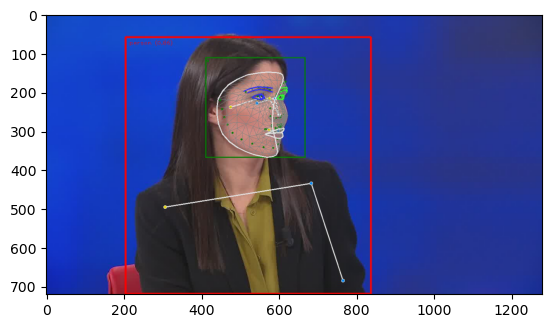

filename                                          img00014.jpeg
detections            [[205, 59, 633, 660, person, 0.85546875]]
poses         [[[0.4697938859462738, 0.35986363887786865, -0...
faces         [[[0.47500377893447876, 0.41058608889579773, -...
text                                                         []
embedding     [254, 3, 254, 0, 3, 1, 8, 254, 6, 254, 253, 25...
fer           [{'location': [411, 669, 111, 369], 'embedding...
Name: 13, dtype: object

In [25]:
view_frame(index)
df.iloc[index]

### Until this point, we have inspected the type and format of our data and briefly visualized the main features. From now on, we will do more complex Exploratory Data Analysis (EDA) to gain insights of our data.

<a id="section2"></a>

# 2. Determine all detected objects

In [26]:
detected_objects = defaultdict(int)

for detections in df['detections']:
    for detection in detections:
        detected_objects[detection[4]]+=1
        
print(detected_objects.keys())

dict_keys(['person', 'dining table', 'chair', 'tie', 'toilet'])


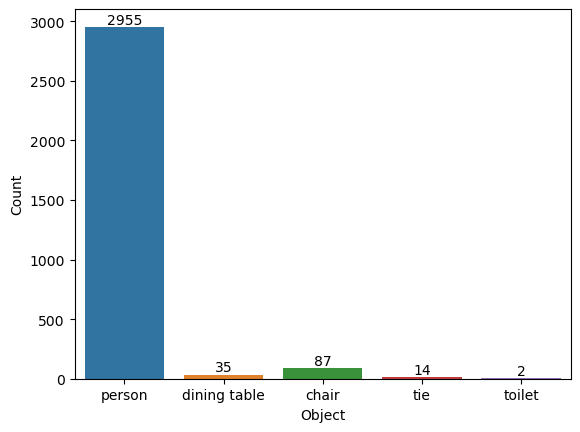

In [27]:
ax = sns.barplot(x=list(detected_objects.keys()), y=list(detected_objects.values()))
plt.xlabel('Object')
plt.ylabel('Count')
for i, value in enumerate(detected_objects.values()):
    ax.text(i, value + 0.3, str(value), ha='center', va='bottom')

plt.show()

## Look at the least frequent detected object

In [28]:
toilet_frames = []
for index, detections in enumerate(df['detections']):
    for detection in detections:
        if detection[4] == 'toilet':
            toilet_frames.append(index)
            
print(toilet_frames)

[971, 1568]


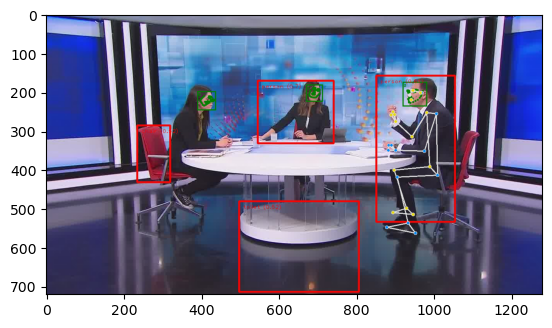

List of all detected objects for frame img00972.jpeg: ['person', 'person', 'chair', 'toilet']


In [29]:
# Select an index from the previous list
index = 971
view_frame(index)

objects = []
for detection in df.iloc[index]['detections']:
    objects.append(detection[4])

frame_id = df.iloc[index]['filename']
print(f"List of all detected objects for frame {frame_id}: {objects}")

<a id="section3"></a>

# 3. Determine all detected emotions

In [30]:
detected_emotions = defaultdict(int)

for observation in df['fer']:
    for fer_object in observation:
        detected_emotions[fer_object['emotion']]+=1
        
print(f"All detected emotions: {list(detected_emotions.keys())}")

All detected emotions: ['Contempt', 'Disgust', 'Surprise', 'Happiness', 'Neutral', 'Sadness', 'Anger', 'Fear']


<a id="emotions-plot"></a>

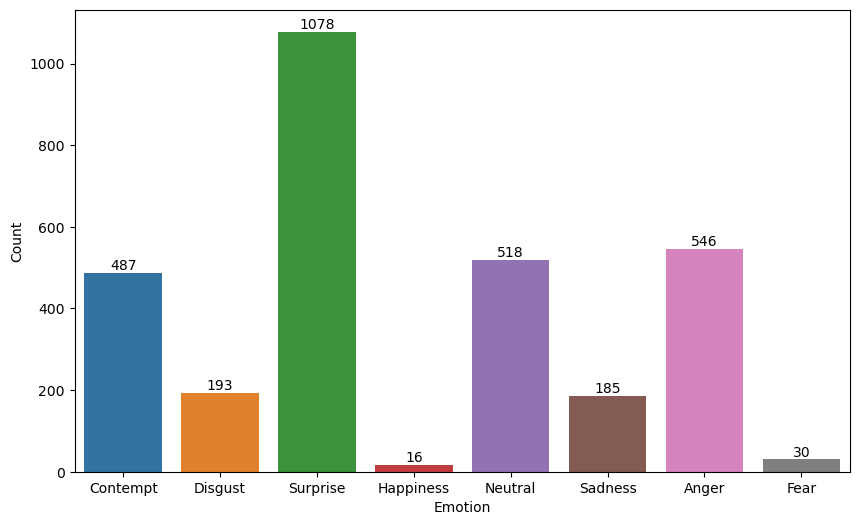

In [31]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=list(detected_emotions.keys()), y=list(detected_emotions.values()))
plt.xlabel('Emotion')
plt.ylabel('Count')
for i, value in enumerate(detected_emotions.values()):
    ax.text(i, value + 0.3, str(value), ha='center', va='bottom')

plt.show()

<a id="section4"></a>

# 4. Determine the detected object with greatest probability score

In [32]:
obj_probs = defaultdict(list)

for detections in df['detections']:
    for detection in detections:
        obj_probs[detection[4]].append(detection[5])

In [33]:
flattened_data = [(key, prob) for key, value in obj_probs.items() for prob in value]
obj_probs = pd.DataFrame(flattened_data, columns=['Object', 'Probability'])

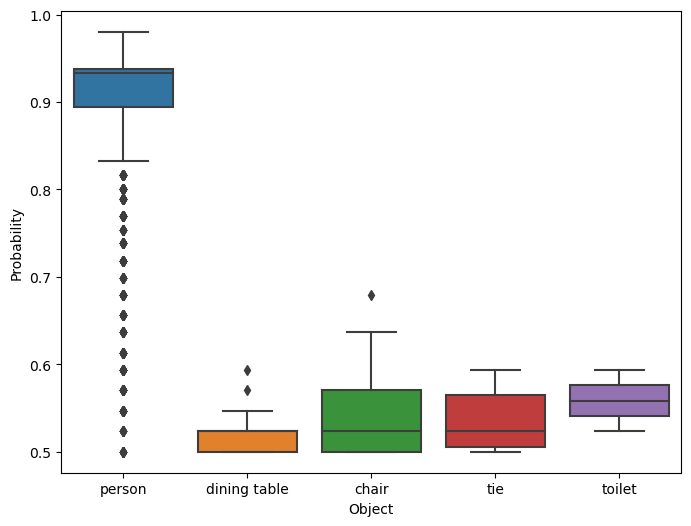

In [34]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Object', y='Probability', data=obj_probs)
plt.show()

### We conclude that 'Person' has the greatest probability score.

## Let's visualize the frames that are considered as outliers

In [35]:
# Available detected objects
det_obj = obj_probs['Object'].unique()
print(det_obj)

['person' 'dining table' 'chair' 'tie' 'toilet']


### Select the detected object:

In [36]:
# Select the object from the list
obj_index = 2

obj = det_obj[obj_index]
print(obj)

chair


In [37]:
# Function to compute the whiskers
def compute_whiskers(probs):
    Q1 = probs.quantile(0.25)
    Q3 = probs.quantile(0.75)
    IQR = Q3-Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    
    return lower_whisker, upper_whisker

In [38]:
lower_whisker, upper_whisker = compute_whiskers(obj_probs[obj_probs['Object']==obj]['Probability'])

In [39]:
outliers = set()
for index, detections in enumerate(df['detections']):
    for detection in detections:
        if detection[4] == obj and (detection[5] < lower_whisker or detection[5] > upper_whisker):
            outliers.add(index)
print(outliers)

{992}


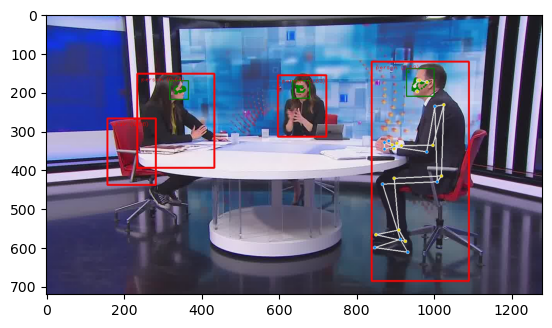

filename                                          img00993.jpeg
detections    [[598, 157, 125, 158, person, 0.83203125], [15...
poses         [[[0.7430697679519653, 0.2575199604034424, -0....
faces                                                        []
text                                                         []
embedding     [255, 253, 2, 3, 255, 253, 254, 2, 253, 253, 2...
fer           [{'location': [929, 1002, 139, 212], 'embeddin...
Name: 992, dtype: object


In [40]:
# Select the outlier
outlier = 992

view_frame(outlier)

print(df.iloc[outlier]) 

## Let's see a more extreme case where the probability is much lower

In [41]:
threshold_prob = 0.51

In [42]:
outliers = set()
for index, detections in enumerate(df['detections']):
    for detection in detections:
        if detection[4] == 'person' and detection[5] < threshold_prob:
            outliers.add(index)
print(outliers)

{576, 1502, 424, 1098, 683, 972, 1264, 81, 20, 1500, 990}


In [43]:
# Select the outlier
outlier = 576

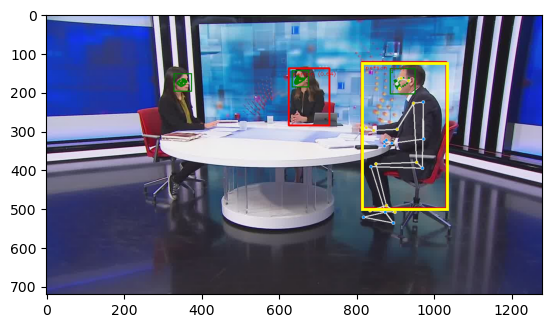

filename                                          img00577.jpeg
detections    [[626, 139, 105, 147, person, 0.63671875], [81...
poses         [[[0.7076138854026794, 0.24942690134048462, -0...
faces                                                        []
text                                                         []
embedding     [255, 253, 4, 0, 255, 254, 254, 2, 255, 254, 2...
fer           [{'location': [634, 678, 144, 188], 'embedding...
Name: 576, dtype: object


In [44]:
obs = df.iloc[outlier]

for detection in obs['detections']:
    if detection[5] < threshold_prob:
        x, y, width, height = detection[0:4]


frame_id = df.iloc[outlier]['filename']
img = Image.open(os.path.join('videos', video, frame_id))
fig, ax = plt.subplots()
ax.imshow(img)

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect)

plt.imshow(img)
plt.show()

print(df.iloc[outlier]) 

### We conclude that despite being considered as outliers according to the box plots, the observations have correctly detected the respective objects. As such, we will consider them as reliable and not discard them for future EDA.

<a id="section5"></a>

# 5. Person analysis

In [45]:
detected_persons = []

for obs in df['detections']:
    N=0
    for detection in obs:
        if detection[4] == 'person':
            N+=1
    detected_persons.append(N)

# Maximum and minimum number of detected persons in a frame
max_persons = max(detected_persons)
min_persons = min(detected_persons)
print(f"max = {max_persons} and min = {min_persons}")

max = 3 and min = 0


### We conclude that at in every frame, between 0 and 3 persons are detected.

In [46]:
# function that retrieves the indices that match the the number of detected persons
def get_persons(x, number):
    n_persons = []
    for i, n in enumerate(x):
        if n == number:
            n_persons.append(i)
    return n_persons

In [47]:
zero_persons = get_persons(detected_persons, 0)
print(zero_persons)

[893]


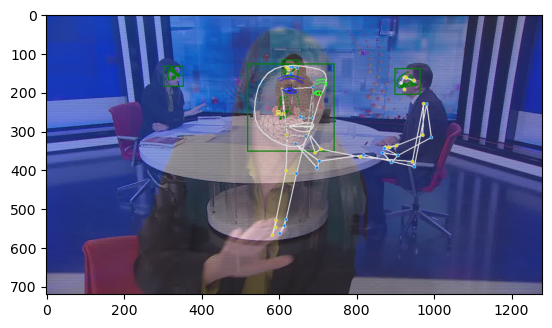

In [48]:
# Observing the image with 0 detected persons
index = 893
view_frame(index)

### We conclude that the image with 0 detected persons is an outlier.

In [49]:
one_persons = get_persons(detected_persons, 1)
print(one_persons)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,

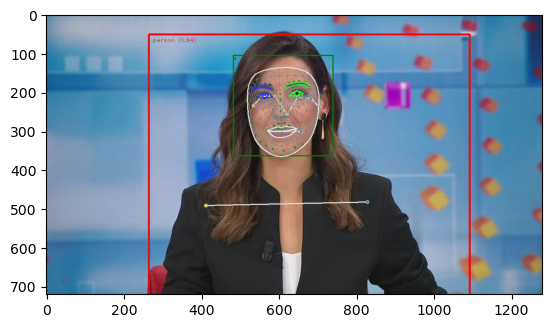

In [50]:
# Observing an image with 1 detected person
index = 0
view_frame(index)

In [51]:
two_persons = get_persons(detected_persons, 2)
print(two_persons)

[20, 21, 22, 23, 24, 25, 26, 27, 80, 81, 82, 84, 85, 86, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 301, 302, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 425, 426, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 574, 575, 576, 577, 578, 582, 583, 584, 585, 586, 587

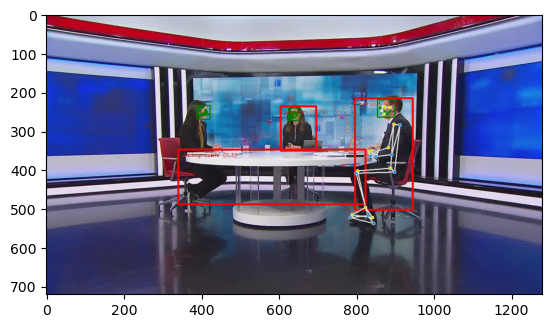

There were detected 2 persons and 3 faces.


In [52]:
# Observing an image with 2 detected persons
index = 20
view_frame(index)

obs = df.iloc[index]
n_persons = 0
for detected in obs['detections']:
        if detected[4]=='person':
            n_persons += 1
n_faces = len(obs['fer'])

print(f'There were detected {n_persons} persons and {n_faces} faces.')

### We notice that in some frames the number of detected persons <span style="color: red;">(red rectangle)</span> is not the same as the number of detected faces <span style="color: green;">(green rectangle)</span>.

In [53]:
three_persons = get_persons(detected_persons, 3)
print(three_persons)

[83, 260, 261, 262, 263, 424, 646, 788, 789, 790, 791, 970, 972, 973, 975, 990, 991, 992, 993, 994, 1096, 1264, 1265, 1269, 1270, 1271, 1500, 1520, 1569, 1570, 1571, 1572, 1617, 1618, 1620, 1782, 1783, 1784, 1785, 2035, 2036, 2037]


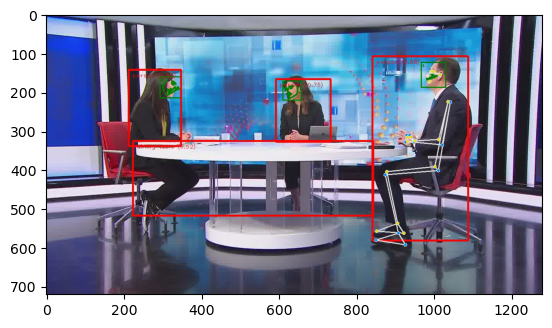

In [54]:
# Observing an image with 3 detected persons
index = 83
view_frame(index)

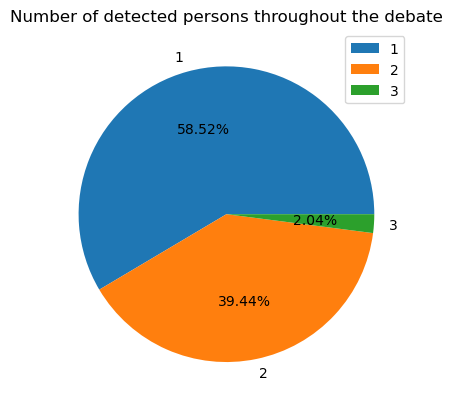

In [55]:
plt.figure()
labels = [1, 2, 3]
sizes = [len(one_persons), len(two_persons), len(three_persons)]
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title('Number of detected persons throughout the debate')
plt.legend(labels, loc='upper right')
plt.show()

<a id="section6"></a>

# 6. Face Analysis

In [56]:
detected_faces = df['fer'].apply(len)

# Maximum and minimum number of detected faces in a frame
max_faces = max(detected_faces)
min_faces = min(detected_faces)
print(f"max = {max_faces} and min = {min_faces}")

max = 4 and min = 1


In [57]:
detected_faces[detected_faces == 4]

893    4
Name: fer, dtype: int64

### We confirm that the frame that has 4 detected faces is the outlier. Ignoring this frame, we conclude that between 1 and 3 faces are detected in each frame.

In [58]:
one_faces = detected_faces[detected_faces == 1].index.to_numpy()
two_faces = detected_faces[detected_faces == 2].index.to_numpy()
three_faces = detected_faces[detected_faces == 3].index.to_numpy()

In [59]:
print(two_faces[0:20])

[168 169 170 171 172 173 174 175 176 177 344 345 346 347 348 349 350 351
 352 353]


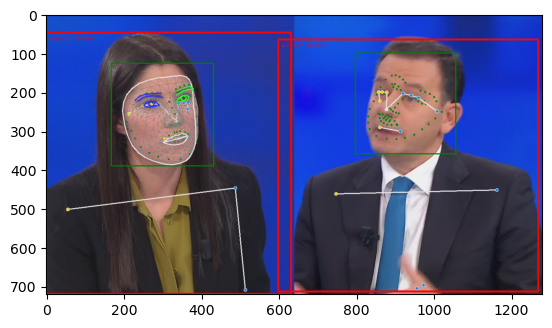

In [60]:
view_frame(168)

## We can now understand all scene segments: 
1) Focused on a person;
2) Focused on two persons;
3) Panorama of both candidates and the journalist.

<a id="face-analysis"></a>

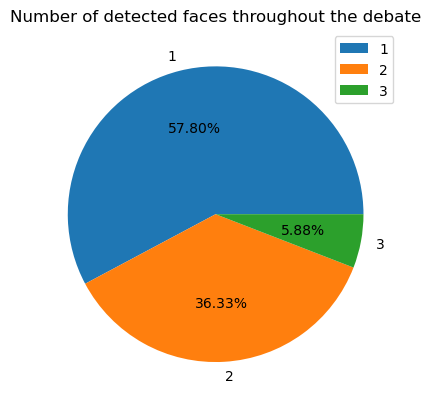

In [61]:
plt.figure()
labels = [1, 2, 3]
sizes = [len(one_faces), len(two_faces), len(three_faces)]
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title('Number of detected faces throughout the debate')
plt.legend(labels, loc='upper right')
plt.show()

<a id="my-plot"></a>

<a id="section7"></a>

# 7. Pose analysis

In [62]:
# Maximum and minimum number of detected poses in a frame
max_poses = df['poses'].apply(len).max()
min_poses = df['poses'].apply(len).min()
print(f"max = {max_poses} and min = {min_poses}")

max = 3 and min = 1


### We conclude that, in every frame, at least one pose is detected and at most three poses are detected.

In [63]:
one_poses = []
for index, obs in enumerate(df['poses']):
    if len(obs) == 1:
        one_poses.append(index)

In [64]:
two_poses = []
for index, obs in enumerate(df['poses']):
    if len(obs) == 2:
        two_poses.append(index)

In [65]:
three_poses = []
for index, obs in enumerate(df['poses']):
    if len(obs) == 3:
        three_poses.append(index)
print(three_poses)

[646, 647]


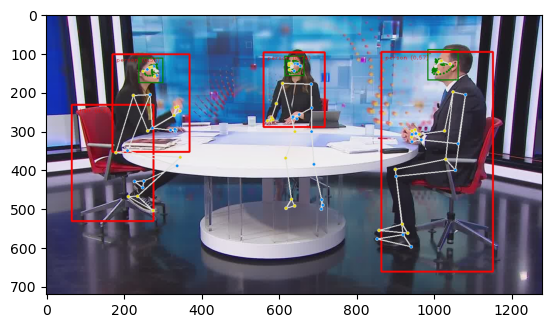

In [66]:
# Let's briefly visualize a frame that has 3 detected poses
view_frame(646)

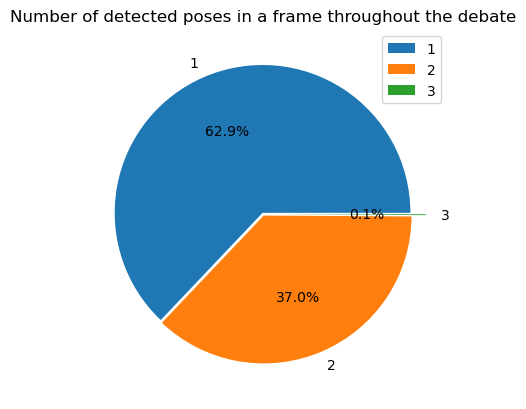

In [67]:
plt.figure()
labels = [1, 2, 3]
sizes = [len(one_poses), len(two_poses), len(three_poses)]
explode=[0.01, 0.01, 0.1]
colors = ['#1f77b4', '#2ca02c', '#800080']
plt.pie(sizes, labels=labels, colors=None, autopct='%1.1f%%', explode=explode)
plt.title('Number of detected poses in a frame throughout the debate')
plt.legend(labels, loc='upper right')
plt.show()

<a id="section8"></a>

# 8. Determine who is the most visible person in the whole debate

<a id="section8.1"></a>

## 8.1 Classification with face embeddings

<a id="section8.1.1"></a>

## 8.1.1 Using the whole dataset

In [68]:
# Function to visually identify which cluster corresponds to each detected person based on image
# Note: This function is hardcoded for the video "ad-be" for convenience and might need to be changed for other videos if the scene differs
# at the beginning
def identify_person(labels):
    cluster_labels = {0, 1, 2}

    for index in one_faces:
        if not cluster_labels:
            break
        label = labels[index]
        if label in cluster_labels:
            if label == 0:
                print('This is Person A:')
            elif label == 1:
                print('This is Person B:')
            elif label == 2:
                print('This is Person C:')

            cluster_labels.remove(label)
            view_frame(index)
        

#### PCA WITH KMEANS

Optimal number of components for 90% explained variance: 26


C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


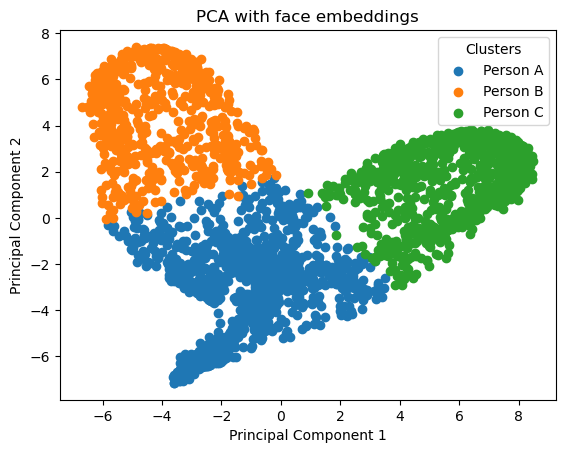

In [69]:
person = []
person_frame = []
for index, obs in enumerate(df['fer']):
    for detected in obs:
        person.append(detected['embedding'])
        person_frame.append(index)

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

data = np.array(list(person))
scaler = StandardScaler()
data = scaler.fit_transform(data)
pca = PCA(n_components=128)
data = pca.fit_transform(data)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

optimal_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print("Optimal number of components for 90% explained variance:", optimal_components)

pca = PCA(n_components=optimal_components)
data = pca.fit_transform(data)

kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=20)
kmeans.fit(data)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

cluster_labels = {0: 'Person A', 1: 'Person B', 2: 'Person C'}
unique_clusters = set(kmeans.labels_)

for cluster_idx in unique_clusters:
    cluster_points = data[kmeans.labels_ == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_labels[cluster_idx])

plt.title('PCA with face embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters', loc='best')
plt.show()

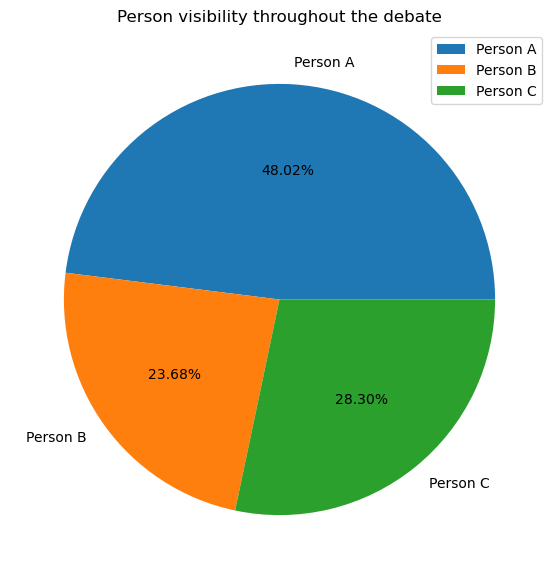

In [70]:
person_occurences = defaultdict(int)
for label in kmeans.labels_:
    person_occurences[label] += 1
    
plt.figure(figsize=(12,7))
labels = ['Person A', 'Person B', 'Person C']

sizes = [person_occurences.get(0), person_occurences.get(1), person_occurences.get(2)]
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title('Person visibility throughout the debate')
plt.legend(labels, loc='upper right')
plt.show()

This is Person A:


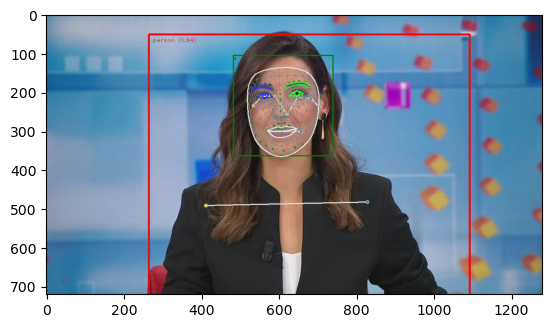

This is Person C:


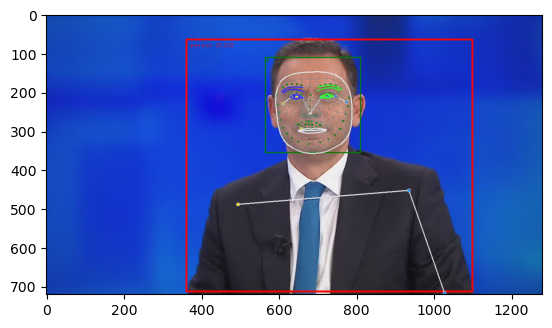

This is Person B:


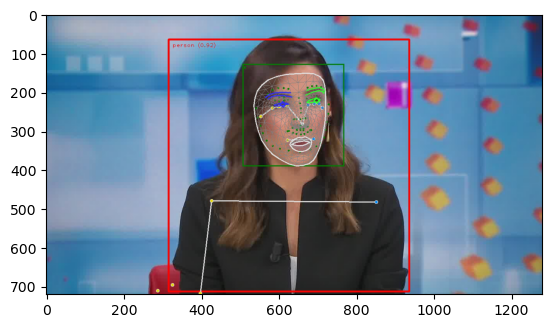

In [71]:
identify_person(kmeans.labels_)

### The model fails to separate persons.

#### PCA WITH GAUSSIAN MIXTURE

Optimal number of components for 90% explained variance: 26


C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


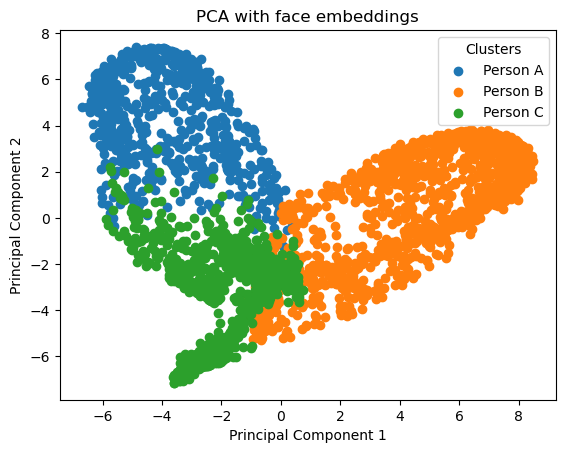

In [72]:
person = []
person_frame = []
for index, obs in enumerate(df['fer']):
    for detected in obs:
        person.append(detected['embedding'])
        person_frame.append(index)

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

data = np.array(list(person))
scaler = StandardScaler()
data = scaler.fit_transform(data)
pca = PCA(n_components=128)
data = pca.fit_transform(data)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

optimal_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print("Optimal number of components for 90% explained variance:", optimal_components)

pca = PCA(n_components=optimal_components)
data = pca.fit_transform(data)


gmm = GaussianMixture(n_components = 3, random_state = random_state, n_init=3)
gmm.fit(data)
gmm_labels = gmm.predict(data)

cluster_labels = {0: 'Person A', 1: 'Person B', 2: 'Person C'}
unique_clusters = set(gmm_labels)

for cluster_idx in unique_clusters:
    cluster_points = data[gmm_labels == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_labels.get(cluster_idx, f"Cluster {cluster_idx}"))

plt.title('PCA with face embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters', loc='best')
plt.show()

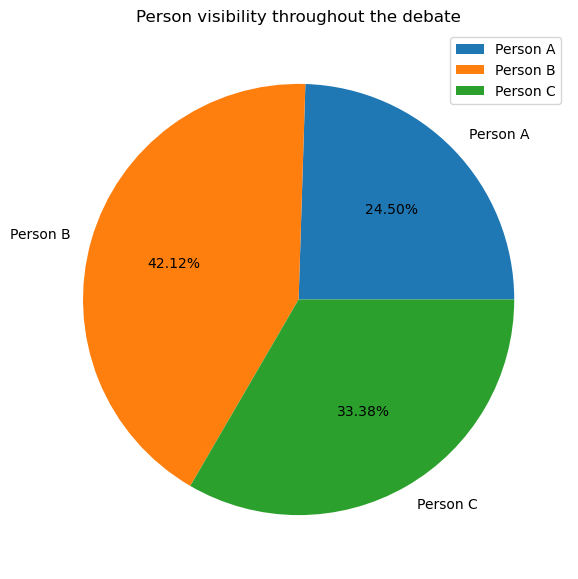

In [73]:
person_occurences = defaultdict(int)
for label in gmm_labels:
    person_occurences[label] += 1

plt.figure(figsize=(12,7))
labels = ['Person A', 'Person B', 'Person C']
sizes = [person_occurences.get(0), person_occurences.get(1), person_occurences.get(2)]
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title('Person visibility throughout the debate')
plt.legend(labels, loc='upper right')
plt.show()

This is Person C:


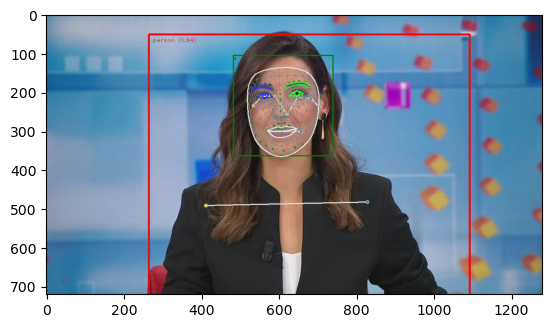

This is Person B:


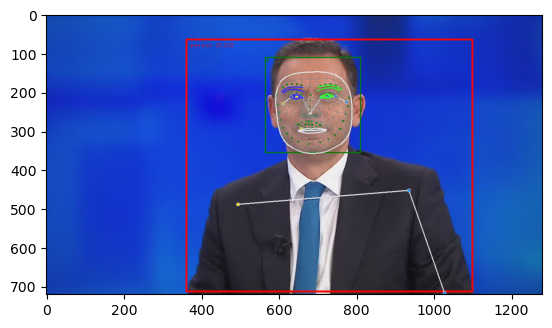

This is Person A:


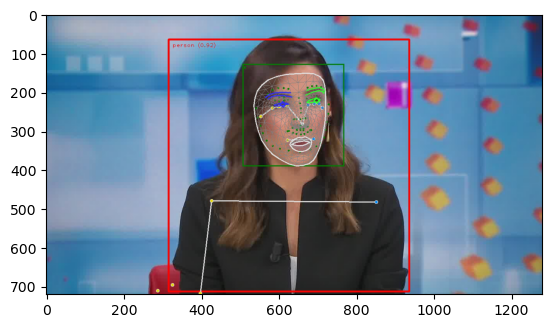

In [74]:
identify_person(gmm_labels)

### Once again, the model fails to separate persons.

### Analysis of the results:

In [75]:
print(one_faces[0:20])
print(kmeans.labels_[0:20])
print(gmm_labels[0:20])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 1 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 0 2]


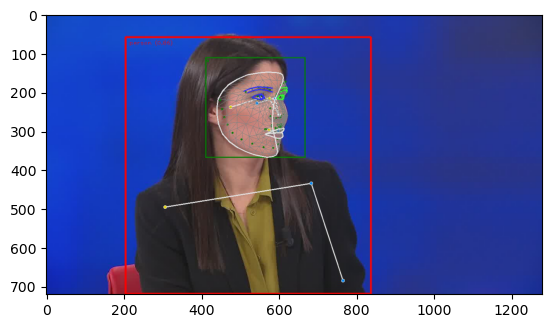

This Person is classifier as the Journalist by both models.


In [76]:
view_frame(13)
print("This Person is classifier as the Journalist by both models.")

### We conclude that both classifiers are prone to confuse Mariana Mortagua with the Journalist. However, the gaussian mixture model appears to have a better performance than the kmeans model.

<a id="section8.1.2"></a>

## 8.1.2 Using only single person scenes

### We will use only focused scenes to ascertain that the face embeddings are as rigorous as possible.

#### PCA WITH GAUSSIAN MIXTURE

Optimal number of components for 90% explained variance: 23


C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


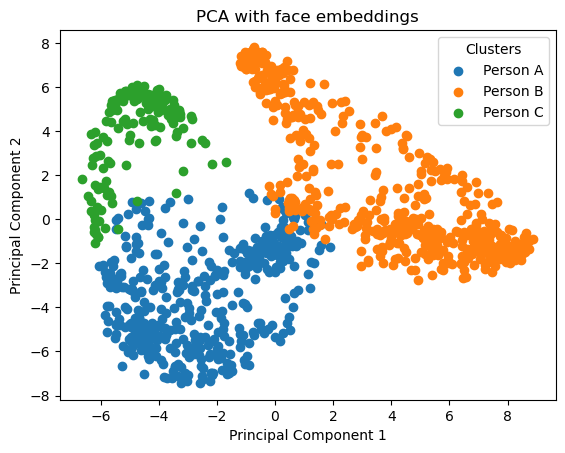

In [77]:
face_classifier = []
for index in one_faces:
    for detected in df.iloc[index]['fer']:
        face_classifier.append((detected['embedding'], index))
        
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

data = np.array([face[0] for face in face_classifier])
scaler = StandardScaler()
data = scaler.fit_transform(data)
pca = PCA(n_components=128)
data = pca.fit_transform(data)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

optimal_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print("Optimal number of components for 90% explained variance:", optimal_components)

pca = PCA(n_components=optimal_components)
data = pca.fit_transform(data)


gmm = GaussianMixture(n_components = 3, random_state = random_state, n_init=3)
gmm.fit(data)
face_labels = gmm.predict(data)

cluster_labels = {0: 'Person A', 1: 'Person B', 2: 'Person C'}
unique_clusters = set(face_labels)

for cluster_idx in unique_clusters:
    cluster_points = data[face_labels == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_labels.get(cluster_idx, f"Cluster {cluster_idx}"))
    
plt.title('PCA with face embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters', loc='best')
plt.show()

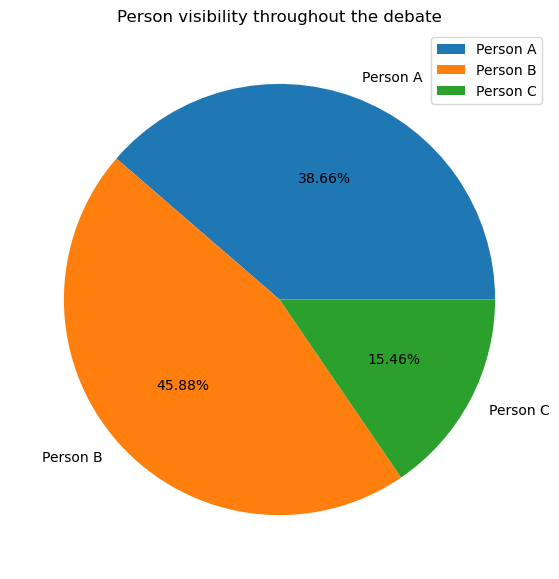

In [78]:
person_occurences = defaultdict(int)
for label in face_labels:
    person_occurences[label] += 1

plt.figure(figsize=(12,7))
labels = ['Person A', 'Person B', 'Person C']
sizes = [person_occurences.get(0), person_occurences.get(1), person_occurences.get(2)]
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title('Person visibility throughout the debate')
plt.legend(labels, loc='upper right')
plt.show()

This is Person A:


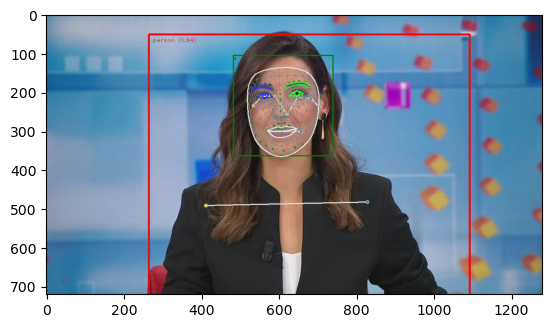

This is Person C:


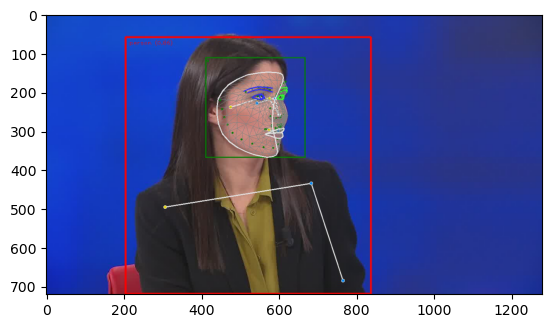

This is Person B:


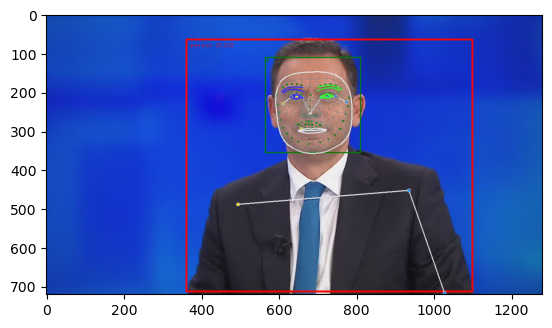

In [79]:
identify_person(face_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 0 0 2]


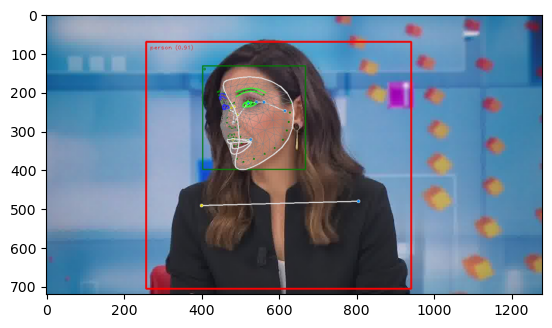

This Person is classified as Mariana Mortagua.


In [80]:
print(one_faces[0:20])
print(face_labels[0:20])
view_frame(35)
print("This Person is classified as Mariana Mortagua.")

### We observe that even with the limited dataset, the model is still prone to confuse Mariana Mortagua with the Journalist. Thus, we conclude that the facial embeddings alone are not sufficient to build a robust model for face classification.

<a id="section8.2"></a>

## 8.2 Person classification with positional embeddings

<a id="section8.2.1"></a>

## 8.2.1 Using only single person scenes

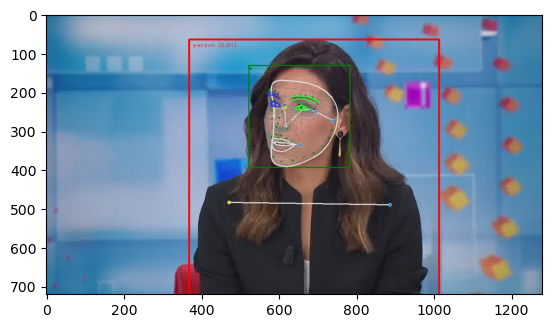

Frame 49 at center = 653


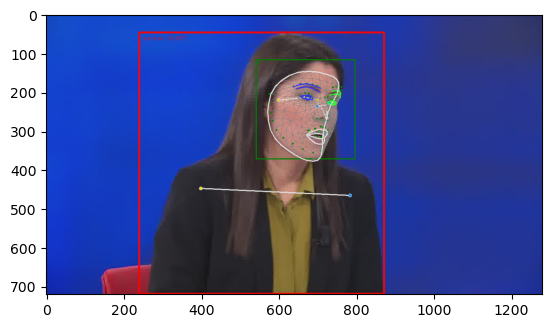

Frame 50 at center = 669


In [105]:
center_list = []
for index in one_faces:
    for detected in df.iloc[index]['fer']:
        loc = detected['location']
        center_x = int((loc[0]+loc[1])/2)
        center = (center_x, index)
        if index==49 or index==50:
            view_frame(index)
            print(f'Frame {index} at center = {center_x}')
        center_list.append(center)

### For single face frames it will still be challenging to handle all cases. We will introduce a distance threshold to try to separate the data.

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


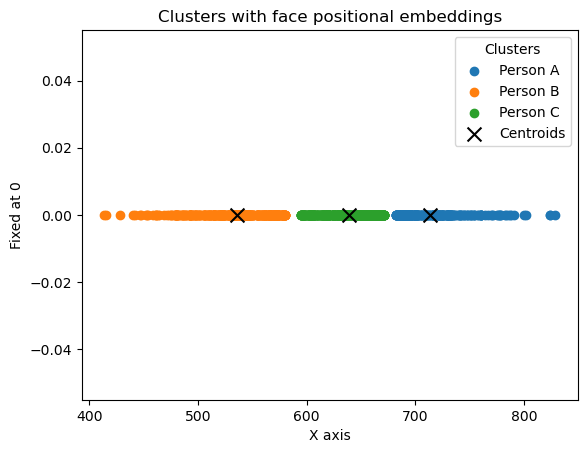

From the original 1190 points, 121 were considered as outliers, resulting in a 10.2% margin of error.


In [84]:
data = np.array([(x[0]) for x in center_list])

random_state = 42

kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=20)
kmeans.fit(data.reshape(-1,1))
cluster_centers = kmeans.cluster_centers_.flatten()
pos_labels = kmeans.labels_

distances = cdist(data.reshape(-1,1), cluster_centers.reshape(-1,1), 'euclidean')
pos_outliers = []

for i in range(len(data)):
    sorted_distances = np.sort(distances[i])  # Sort distances to get nearest and second nearest
    distance_to_nearest = sorted_distances[0]
    distance_to_second_nearest = sorted_distances[1]

    # Select threshold
    if distance_to_nearest > 0.75 * distance_to_second_nearest:
        pos_outliers.append(i) 

pos_classifier = np.array([item for i, item in enumerate(center_list) if i not in pos_outliers])
data = np.delete(data, pos_outliers)
pos_labels = np.delete(pos_labels, pos_outliers)


cluster_labels = {0: 'Person A', 1: 'Person B', 2: 'Person C'}
unique_clusters = set(kmeans.labels_)
    
# 1D clusters
for cluster_idx in range(3):
    cluster_points = data[pos_labels == cluster_idx]
    plt.scatter(cluster_points, np.zeros_like(cluster_points), label=cluster_labels[cluster_idx])

plt.scatter(cluster_centers, [0] * len(cluster_centers), color='black', marker='x', s=100, label='Centroids')
    
plt.title('Clusters with face positional embeddings')
plt.xlabel('X axis')
plt.ylabel('Fixed at 0')
plt.legend(title='Clusters', loc='best')
plt.show()

print(f"From the original {len(center_list)} points, {len(pos_outliers)} were considered as outliers, resulting in a {round(float(len(pos_outliers)/len(center_list)*100),1)}% margin of error.")

In [85]:
arr_0 = []
arr_1 = []
arr_2 = []
for pos, label in zip(pos_classifier, pos_labels):
    if label == 0:
        arr_0.append(pos[0])
    elif label == 1:
        arr_1.append(pos[0])
    else:
         arr_2.append(pos[0])

This is Person C:


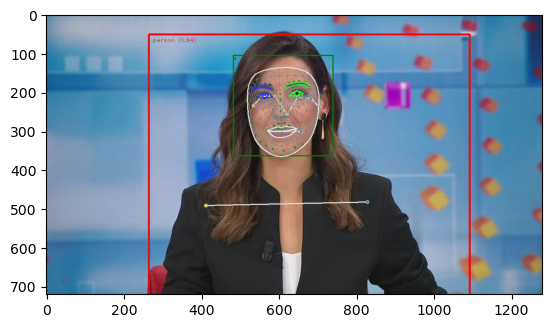

This is Person B:


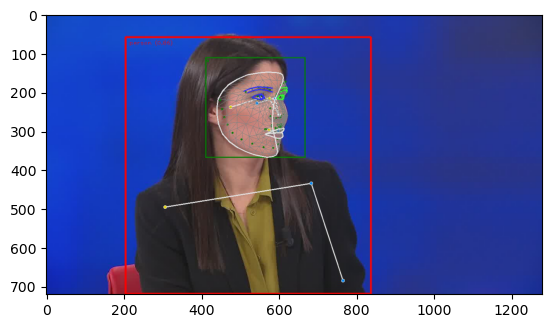

This is Person A:


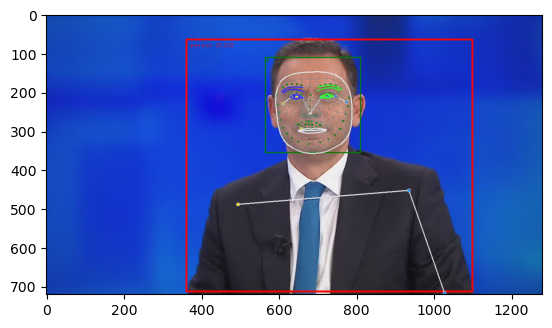

The boundaries for the centers are:
	 Person A: [682, 829]
	 Person B: [414, 580]
	 Person C: [595, 671]


In [86]:
identify_person(pos_labels)
print(f"The boundaries for the centers are:\n\t Person A: [{min(arr_0)}, {max(arr_0)}]" +
      f"\n\t Person B: [{min(arr_1)}, {max(arr_1)}]\n\t Person C: [{min(arr_2)}, {max(arr_2)}]")

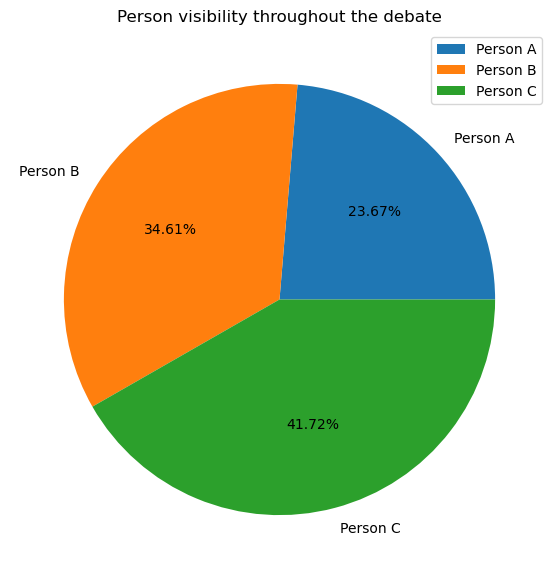

In [87]:
person_occurences = defaultdict(int)
for label in pos_labels:
    person_occurences[label] += 1

plt.figure(figsize=(12,7))
plabels = ['Person A', 'Person B', 'Person C']
sizes = [person_occurences.get(0), person_occurences.get(1), person_occurences.get(2)]
plt.pie(sizes, labels=plabels, autopct='%1.2f%%')
plt.title('Person visibility throughout the debate')
plt.legend(plabels, loc='upper right')
plt.show()

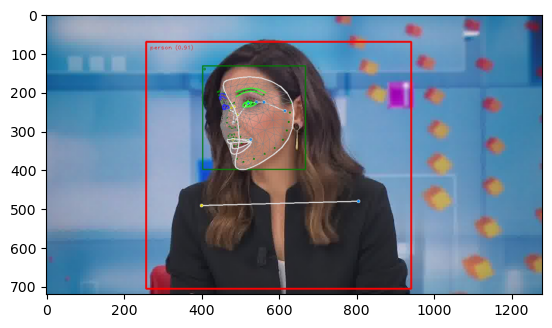

Center at x = 536. This person was classified as Mariana Mortagua.


In [88]:
view_frame(35)
print(f"Center at x = {pos_classifier[24][0]}. This person was classified as Mariana Mortagua.")

### As expected, positional clustering might be difficult for single person frames. But what about for frames where more than one face is detected?

<a id="section8.2.2"></a>

## 8.2.2 Using only two person scenes

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


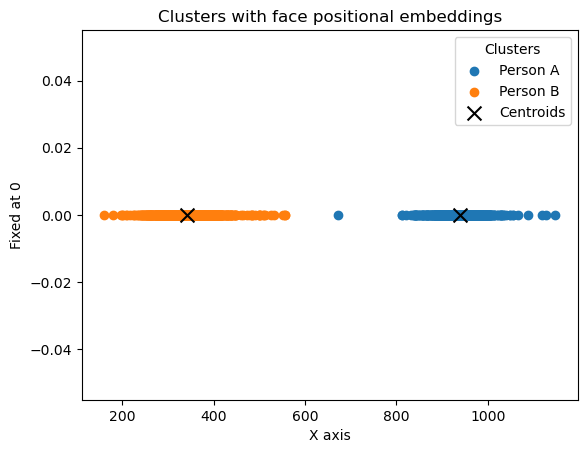

From the original 1496 points, 0 were considered as outliers, resulting in a 0.0% margin of error.


In [89]:
center_list = []
for index in two_faces:
    for detected in df.iloc[index]['fer']:
        loc = detected['location']
        center_x = int((loc[0]+loc[1])/2)
        center = (center_x, index)
        center_list.append(center)

data = np.array([(x[0]) for x in center_list])

random_state = 42

kmeans = KMeans(n_clusters=2, random_state=random_state, n_init=10)
kmeans.fit(data.reshape(-1,1))
cluster_centers = kmeans.cluster_centers_.flatten()
labels = kmeans.labels_

distances = cdist(data.reshape(-1,1), cluster_centers.reshape(-1,1), 'euclidean')
outliers = []

for i in range(len(data)):
    sorted_distances = np.sort(distances[i])  # Sort distances to get nearest and second nearest
    distance_to_nearest = sorted_distances[0]
    distance_to_second_nearest = sorted_distances[1]
    
    # Select threshold
    if distance_to_nearest > 1 * distance_to_second_nearest:
        outliers.append(i) 

filtered_center_list = [item for i, item in enumerate(center_list) if i not in outliers]
data = np.delete(data, outliers)
labels = np.delete(labels, outliers)

cluster_labels = {0: 'Person A', 1: 'Person B', 2: 'Person C'}
unique_clusters = set(kmeans.labels_)
    
# 1D clusters
for cluster_idx in range(2):
    cluster_points = data[labels == cluster_idx]
    plt.scatter(cluster_points, np.zeros_like(cluster_points), label=cluster_labels[cluster_idx])

plt.scatter(cluster_centers, [0] * len(cluster_centers), color='black', marker='x', s=100, label='Centroids')
    
plt.title('Clusters with face positional embeddings')
plt.xlabel('X axis')
plt.ylabel('Fixed at 0')
plt.legend(title='Clusters', loc='best')
plt.show()

print(f"From the original {len(center_list)} points, {len(outliers)} were considered as outliers, resulting in a {round(float(len(outliers)/len(center_list)*100),1)}% margin of error.")

(672, 690)


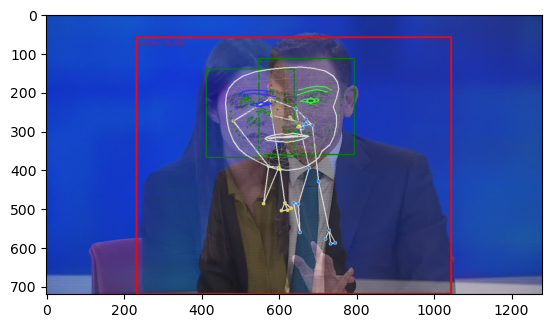

In [90]:
# Outlier that was removed
for i in center_list:
    if i[0] > 600 and i[0] < 800:
        print(i)
view_frame(690)

### We detected another outlier.

### By visualizing the clusters, we can conclude that the frames where two faces are detected show the two candidates and never the journalist.

<a id="section8.2.3"></a>

## 8.2.3 Using only panorama scenes

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


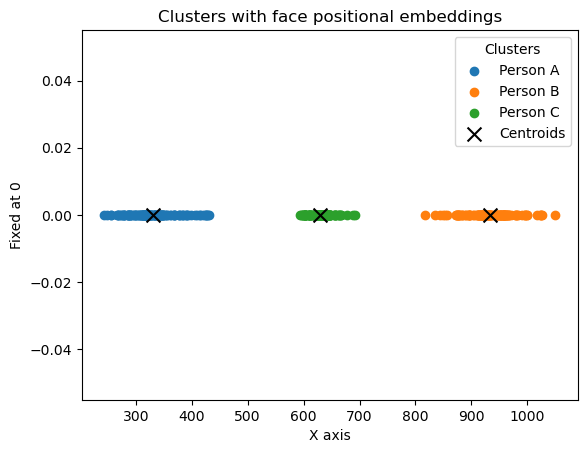

From the original 363 points, 0 were considered as outliers, resulting in a 0.0% margin of error.


In [91]:
center_list = []
for index in three_faces:
    for detected in df.iloc[index]['fer']:
        loc = detected['location']
        center_x = int((loc[0]+loc[1])/2)
        center = (center_x, index)
        center_list.append(center)

data = np.array([(x[0]) for x in center_list])

random_state = 42

kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=10)
kmeans.fit(data.reshape(-1,1))
cluster_centers = kmeans.cluster_centers_.flatten()
labels = kmeans.labels_

distances = cdist(data.reshape(-1,1), cluster_centers.reshape(-1,1), 'euclidean')
outliers = []

for i in range(len(data)):
    sorted_distances = np.sort(distances[i])  # Sort distances to get nearest and second nearest
    distance_to_nearest = sorted_distances[0]
    distance_to_second_nearest = sorted_distances[1]
    
    # Select threshold
    if distance_to_nearest > 0.8 * distance_to_second_nearest:
        outliers.append(i) 

filtered_center_list = [item for i, item in enumerate(center_list) if i not in outliers]
data = np.delete(data, outliers)
labels = np.delete(labels, outliers)

cluster_labels = {0: 'Person A', 1: 'Person B', 2: 'Person C'}
unique_clusters = set(kmeans.labels_)
    
# 1D clusters
for cluster_idx in range(3):
    cluster_points = data[labels == cluster_idx]
    plt.scatter(cluster_points, np.zeros_like(cluster_points), label=cluster_labels[cluster_idx])

plt.scatter(cluster_centers, [0] * len(cluster_centers), color='black', marker='x', s=100, label='Centroids')
    
plt.title('Clusters with face positional embeddings')
plt.xlabel('X axis')
plt.ylabel('Fixed at 0')
plt.legend(title='Clusters', loc='best')
plt.show()

print(f"From the original {len(center_list)} points, {len(outliers)} were considered as outliers, resulting in a {round(float(len(outliers)/len(center_list)*100),1)}% margin of error.")

### After analysing the face and positional embeddings, we can conclude that by accurately classifying each person in the single person frames, we can determine who is the most visible person in the debate. Thus, from now on, we will target only the single person scenes.

<a id="section8.3"></a>

## 8.3 Comparison between face and positional classifications

### Hypothesis: How about we only consider the ones that classify the same person for the face embeddings and positional embeddings? Maybe we can use positional encodings to aid distinguish faces of the same gender!

<a id="section8.3.1"></a>

## 8.3.1 For both genders

In [92]:
filtered_face_classifier = [x for i, x in enumerate(face_classifier) if i not in pos_outliers]
filtered_face_labels = [x for i, x in enumerate(face_labels) if i not in pos_outliers]
# pos_classifier
# pos_labels

new_face_labels = np.empty(len(filtered_face_labels), dtype=object)
for index, label in enumerate(filtered_face_labels):
    if label == 0:
        new_face_labels[index] = 'Journalist'
    elif label == 1:
        new_face_labels[index] = 'Montenegro'
    else:
        new_face_labels[index] = 'Mortagua'

new_pos_labels = np.empty(len(pos_labels), dtype=object)
for index, label in enumerate(pos_labels):
    if label == 0:
        new_pos_labels[index] = 'Montenegro'
    elif label == 1:
        new_pos_labels[index] = 'Mortagua'
    else:
        new_pos_labels[index] = 'Journalist'

In [93]:
equal = []
diff = []
for index, (label1, label2) in enumerate(zip(new_face_labels, new_pos_labels)):
    if label1 == label2:
        equal.append(pos_classifier[index][1])
    else:
        diff.append(pos_classifier[index][1])
        
print(f"There are {len(equal)} matches out of {len(new_face_labels)} samples, i.e. {round(float((1-len(equal)/len(new_face_labels))*100),2)}% difference.")

There are 429 matches out of 1069 samples, i.e. 59.87% difference.


<a id="section8.3.2"></a>

## 8.3.2 For only females

In [94]:
equal = []
diff = []
luis = []
for index, (label1, label2) in enumerate(zip(new_face_labels, new_pos_labels)):
    if label1 == label2 and label1 != 'Montenegro':
        equal.append(pos_classifier[index][1])
    elif label1 != label2 and label2 != 'Montenegro':
        diff.append(pos_classifier[index][1])
    else:
        luis.append(pos_classifier[index][1])

print(f"There are {len(equal)} matches out of {len(equal)+len(diff)} female samples, i.e. {round(float((1-len(equal)/(len(equal)+len(diff)))*100),2)}% difference.")

There are 215 matches out of 816 female samples, i.e. 73.65% difference.


### If the face classifications and positional classification produced similar results up to a certain degree, we could come up with a metric to accurately classify the persons. However, since the results differ substantially for both techniques, we will look for another way.

<a id="section8.4"></a>

# 8.4 Image embeddings classification

Optimal number of components for 90% explained variance: 396


C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


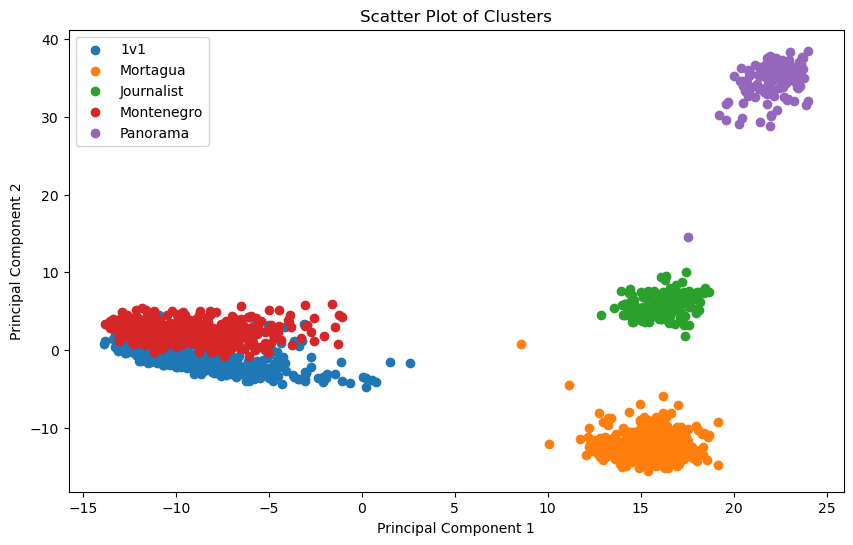

In [95]:
embeddings = np.array(df['embedding'].tolist())  # Convert list of embeddings to a numpy array
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

pca = PCA(n_components=1024)
embeddings = pca.fit_transform(embeddings)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

optimal_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print("Optimal number of components for 90% explained variance:", optimal_components)

pca = PCA(n_components=optimal_components)
data = pca.fit_transform(embeddings)

# Choose a number of clusters to start with, for example, k=5
kmeans = KMeans(n_clusters=5, random_state=0,n_init=5).fit(embeddings)

# Assign a cluster label to each frame
df['cluster_label'] = kmeans.labels_

# Define a dictionary to map cluster labels to names
cluster_names = {
    0: '1v1',
    1: 'Mortagua',
    2: 'Journalist',
    3: 'Montenegro',
    4: 'Panorama'
}

pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
principal_components = pca.fit_transform(embeddings)

# Add these components as new columns to your DataFrame
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

# Plot each cluster with its own color and label
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
for cluster_idx in range(kmeans.n_clusters):
    # Select df points that belong to the current cluster
    cluster_points = df[df['cluster_label'] == cluster_idx]
    
    # Plot points using the two principal components
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=cluster_names.get(cluster_idx, f"Cluster {cluster_idx}"))

plt.title('Scatter Plot of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()  # Show legend
plt.show()

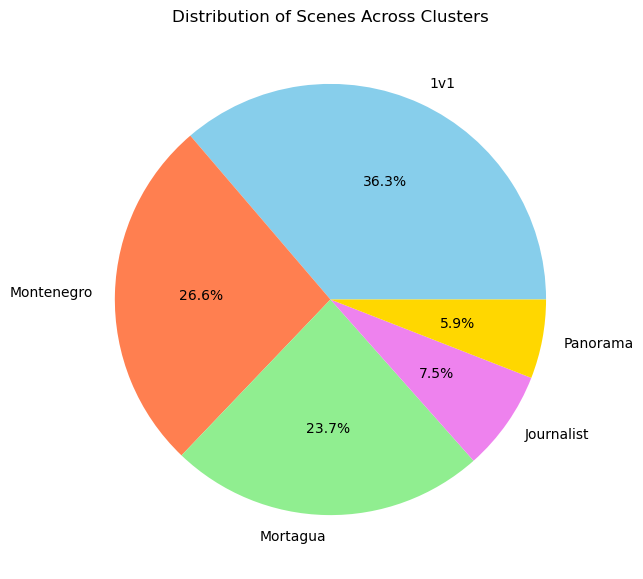

In [96]:
cluster_counts = df['cluster_label'].value_counts()

# Get the cluster names in the same order as the cluster counts
labels = [cluster_names[label] for label in cluster_counts.index]

# Plotting the distribution of clusters with a pie chart
plt.figure(figsize=(12,7))
plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'coral', 'lightgreen', 'violet', 'gold'])
plt.title('Distribution of Scenes Across Clusters')
plt.show()

### Most clusters are clearly separable. The nearest ones are Montenegro and the 1v1 scene clusters, however these can be easily differentiated if we partition the dataset for the number of faces detected. However, we must also take into consideration that visualizing with PCA doesn't reflect the true structure of the data in high dimensions.

### What gives us confidence in this classification model is that the scene distribution that was obtained through clustering is equal to the ones back in Face Analysis Section: [Jump to Face Analysis Pie Plot](#face-analysis). 

### This allows us to put more trust in the results.

### We finally conclude that the person with the most visibility in the debate is Montenegro.

## Verification: Check if there are frames wrongfully classified as Montenegro or 1v1.

In [97]:
df.head()

filename                                 detections  \
0  img00001.jpeg  [[265, 52, 828, 673, person, 0.94140625]]   
1  img00002.jpeg  [[278, 38, 828, 673, person, 0.94140625]]   
2  img00003.jpeg  [[248, 59, 860, 660, person, 0.92578125]]   
3  img00004.jpeg      [[265, 59, 828, 660, person, 0.9375]]   
4  img00005.jpeg  [[248, 65, 860, 648, person, 0.93359375]]   

                                               poses  \
0  [[[0.4862446188926697, 0.35852527618408203, -0...   
1  [[[0.48350581526756287, 0.35224926471710205, -...   
2  [[[0.49067580699920654, 0.37244391441345215, -...   
3  [[[0.49766069650650024, 0.3745940923690796, -0...   
4  [[[0.493888258934021, 0.387317419052124, -0.67...   

                                               faces text  \
0  [[[0.4748454988002777, 0.40552443265914917, -0...   []   
1  [[[0.47546878457069397, 0.4042942523956299, -0...   []   
2  [[[0.47725796699523926, 0.4246514141559601, -0...   []   
3  [[[0.4811995029449463, 0.42986831068992615, -0...   []   
4  [[[0.48391252756118774, 0.4281001687049866, -0...   []   

                                           embedding  \
0  [253, 4, 253, 1, 2, 6, 255, 253, 1, 1, 253, 3,...   
1  [253, 3, 253, 2, 3, 5, 255, 253, 2, 1, 253, 4,...   
2  [253, 3, 253, 0, 3, 6, 0, 253, 2, 2, 253, 6, 6...   
3  [253, 4, 254, 0, 4, 3, 0, 253, 2, 2, 253, 4, 7...   
4  [253, 3, 253, 0, 3, 5, 255, 253, 2, 2, 253, 4,...   

                                                 fer  cluster_label  \
0  [{'location': [482, 741, 105, 365], 'embedding...              2   
1  [{'location': [482, 742, 104, 365], 'embedding...              2   
2  [{'location': [493, 750, 121, 379], 'embedding...              2   
3  [{'location': [493, 753, 120, 381], 'embedding...              2   
4  [{'location': [493, 750, 128, 386], 'embedding...              2   

         PC1       PC2  
0  15.495306  4.484229  
1  15.982924  3.999561  
2  15.171958  4.297981  
3  15.419965  4.459515  
4  15.903162  4.430069

In [98]:
wrong_count = 0
wrong = []
for index, row in df.iterrows():
    if row['cluster_label'] == 3 and len(row['fer']) > 1:
        wrong_count += 1
        wrong.append(index)
    elif row['cluster_label'] == 0 and len(row['fer']) == 1:
        wrong_count += 1
        wrong.append(index)
print(f"Number of incorrect data points is {wrong_count}.")

Number of incorrect data points is 0.


### We conclude that there were no wrongfully classified scenes.

<a id="section9"></a>

# 9. Scene dynamics over time

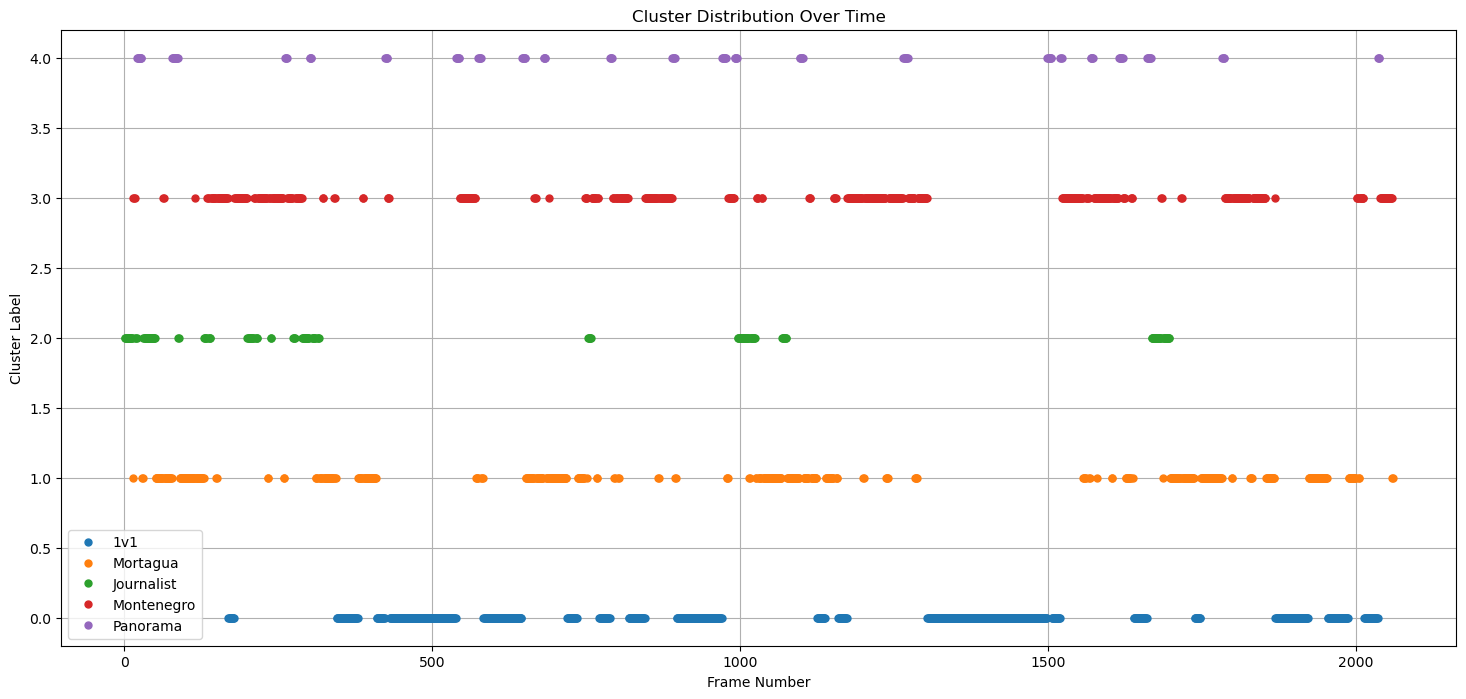

In [99]:
df['frame_number'] = df['filename'].str.extract('(\d+)').astype(int)

df.sort_values('frame_number', inplace=True)

plt.figure(figsize=(18, 8))
for cluster in sorted(df['cluster_label'].unique()):
    subset = df[df['cluster_label'] == cluster]
    cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
    plt.plot(subset['frame_number'], subset['cluster_label'], label=cluster_name, marker='o', linestyle='', markersize=5)

plt.xlabel('Frame Number')
plt.ylabel('Cluster Label')
plt.title('Cluster Distribution Over Time')
plt.legend()
plt.grid(True)
plt.show()

### We can take some interesting information from this plot. For instance: 
- The journalist has more appearances at the beginning of the debate and later appears for only short spans of time.
- Scenes that focus on both candidates have longer duration.
- Panorama scenes repeat more or less periodically.

<a id="section10"></a>

# 10. Emotions in 1v1 scenes

In [100]:
# A function to generate pairs from a list of emotions
def generate_pairs(emotion_list):
    if len(emotion_list) == 2:
        return [tuple(sorted(emotion_list))]
    else:
        return []

# Collecting all emotions in pairs
emotion_pairs = []
for idx in range(df.shape[0]):
    frame_emotions = [fer['emotion'] for fer in df.iloc[idx]['fer'] if 'emotion' in fer]
    emotion_pairs.extend(generate_pairs(frame_emotions))

# Counting each pair
emotion_pair_count = Counter(emotion_pairs)

# Sorting the pairs by count
sorted_emotion_pairs = {k: v for k, v in sorted(emotion_pair_count.items(), key=lambda item: item[1], reverse=True)}

# Extracting labels and counts for plotting
labels = [' & '.join(k) for k in sorted_emotion_pairs.keys()]
counts = list(sorted_emotion_pairs.values())  # Convert dict_values to list for subscripting

In [101]:
marine_blue  = (0.0, 0.2, 0.4)
# Define colors for each emotion
emotion_colors = {
    'Surprise': 'cyan',
    'Disgust': 'magenta',
    'Neutral': 'gray',
    'Sadness': 'blue',
    'Anger': 'red',
    'Contempt': 'orange',
    'Fear': 'purple',
    'Happiness': 'green'
}

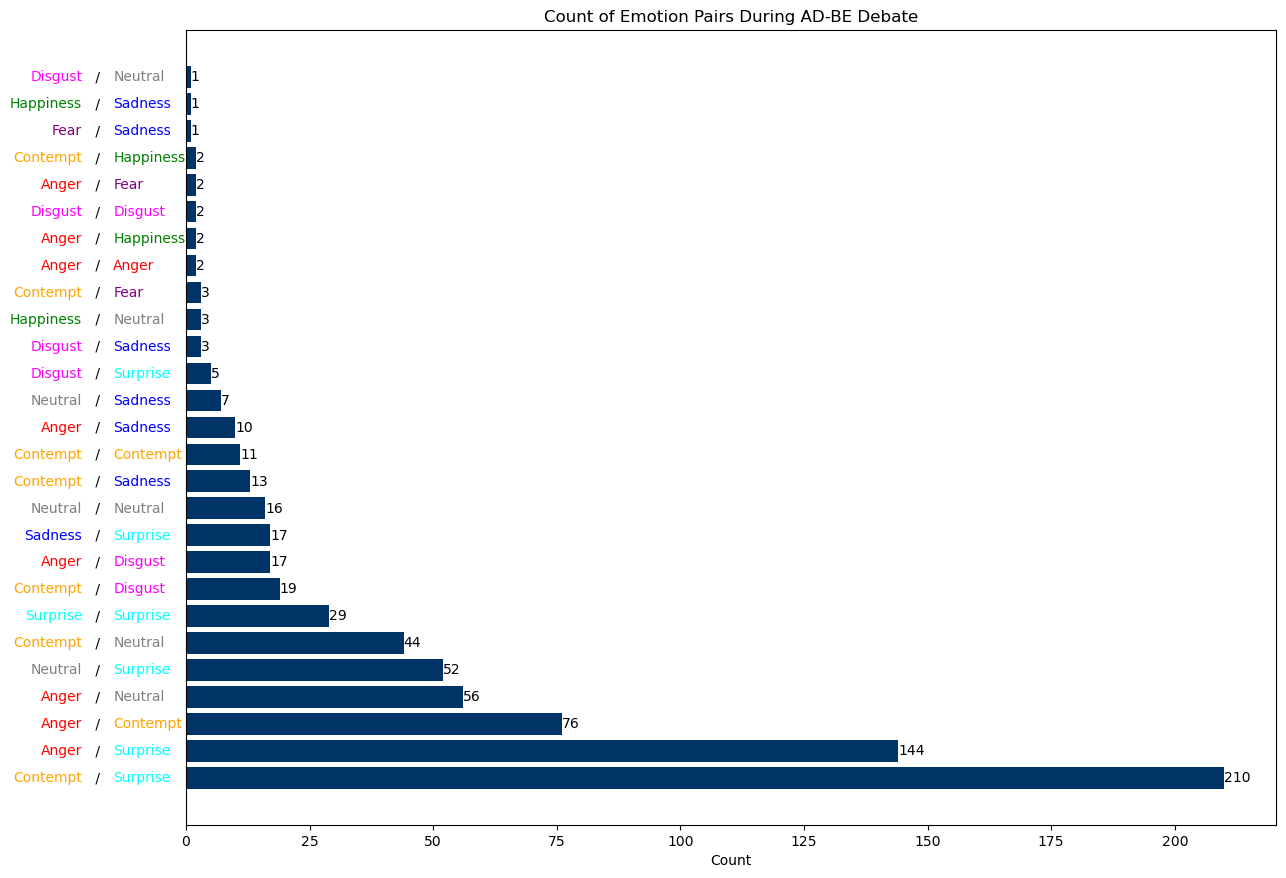

In [102]:
# Plotting the pairs
plt.figure(figsize=(13, 9)) 
bars = plt.barh(range(len(labels)), counts, color=marine_blue)
plt.title("Count of Emotion Pairs During AD-BE Debate")
plt.xlabel("Count")

# Adding counts on the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, counts[i], va='center')

# Adding y-axis labels with each word colored according to emotion
for i, word in enumerate(labels):
    words = word.split(' & ')
    plt.text(-0.1 * max(counts), i, words[0], ha='right', va='center', color=emotion_colors[words[0]], fontsize=10)
    plt.text(-0.085 * max(counts), i, ' / ', ha='center', va='center', color='black', fontsize=10)
    plt.text(-0.070 * max(counts), i, words[1], ha='left', va='center', color=emotion_colors[words[1]], fontsize=10)

plt.gca().set_yticks([])  # Remove default y-ticks

plt.tight_layout(pad=1.5, rect=(0, 0, 1, 1))  # Add padding to the left side of the plot

plt.show()

### We observe that the most common pair is contempt/surprise. 

### These pairwise emotions are concordant with the emotion distribution plot previously seen in Section 2: [Jump to Emotions Bar plot](#emotions-plot)

------------------------------
# Authors
<p style="font-size: 20px; line-height: 1.2;">
<strong>Diogo Miranda (96190)</strong><br>
<strong>João Martins (99983)</strong><br>
<strong>Miguel Bandeira (100035)</strong>
</p>